In [ ]:
!pip install optuna

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [183]:
import random
import os
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optimizers

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

import optuna

In [22]:
def seed_set(seed):
    """
    seedの固定

    Parameters
    --------------
    seed : int
        シード
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # https://qiita.com/chat-flip/items/c2e983b7f30ef10b91f6
        torch.backends.cudnn.deterministic = True  # 決定論的な振る舞いをする
        torch.backends.cudnn.benchmark = False

In [4]:
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla P100-PCIE-16GB


## Config

In [5]:
%cd /content/drive/My\ Drive/fueki/text/

/content/drive/My Drive/fueki/text


In [6]:
SEED = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TRAIN_FILE = "./dataset/train.csv"
TEST_FILE = "./dataset/test.csv"
MODELS_DIR = "./models/"
MODEL_NAME = 'bert-base-uncased'
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 128
NUM_CLASSES = 4
EPOCHS = 5
NUM_SPLITS = 5

In [23]:
seed_set(SEED)

## Dataset

In [9]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

In [10]:
df_train.head()

,id,description,jobflag
0,0,"Executes and writes portions of testing plans,...",2
1,1,Maintain Network Performance by assisting with...,3
2,2,Supports the regional compliance manager with ...,4
3,3,Keep up to date with local and national busine...,1
4,4,Assist with Service Organization Control (SOC)...,4


In [11]:
class MyDataset(Dataset):
    def __init__(self, df_train, df_test, train_test):
        df_train['word_list'] = df_train['description'].apply(lambda x: re.sub('\W | \s', '', x).split())
        df_test['word_list'] = df_test['description'].apply(lambda x: re.sub('\W | \s', '', x).split())

        self.vocab = set(sum(df_train['word_list'].tolist() + df_test['word_list'].tolist(), []))
        self.vocab_size = len(self.vocab)
        self.train_test = train_test

        # 単語にインデックスを付与（word to index, index to word）
        self.word2id = {w: i for i, w in enumerate(self.vocab)}
        self.id2word = {i: w for i, w in enumerate(self.vocab)}

        self.context = []
        self.target = []
        self.label = []

        if self.train_test == 'train':
            for i in range(len(df_train)):
                for context, target, label in self.create_cbow_dataset(df_train['word_list'].iloc[i], df_train['jobflag'].iloc[i]-1):
                    self.context.append(context)
                    self.target.append(target)
                    self.label.append(label)
        else:
            for i in range(len(df_test)):
                for context, target, label in self.create_cbow_dataset(df_train['word_list'].iloc[i]):
                    self.context.append(context)
                    self.target.append(target)

    def __len__(self):
        return len(self.context)

    def __getitem__(self, index):
        if self.train_test == 'train':
            return [self.word2id[w] for w in self.context[index]], self.word2id[self.target[index]], self.label[index]
        else:
            return [self.word2id[w] for w in self.context[index]], self.word2id[self.target[index]]

    # データセットの準備（window size=2）
    def create_cbow_dataset(self, text, label=None):
        data = []
        # 周辺単語, ターゲット単語の組み合わせを習得
        for i in range(2, len(text) - 2):
            context = [text[i - 2], text[i - 1],
                    text[i + 1], text[i + 2]]
            target = text[i]
            data.append((context, target, label))
        return data

In [12]:
def collate_fn(batch):
    contexts = []
    targets_labels = []

    for sample in batch:
        contexts.append(torch.LongTensor(sample[0]))
        targets_labels.append(torch.LongTensor(sample[1:]))
    
    return torch.stack(contexts, dim=0), torch.stack(targets_labels, dim=0)

In [58]:
seed_set(SEED)

train_dataset = MyDataset(df_train, df_test, 'train')
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

test_dataset = MyDataset(df_train, df_test, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [59]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_size, context_size, hidden_size, class_num=4):
        super(CBOW, self).__init__()

        self.context_size = context_size
        self.embed_size = embed_size

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.linear1 = nn.Linear(2*context_size*embed_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

        self.linear_label = nn.Linear(hidden_size, class_num)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view(-1, 2*self.context_size*self.embed_size)
        
        hid = F.relu(self.linear1(embedded))
        targets_out = self.linear2(hid)
        labels_out = self.linear_label(hid)

        return targets_out, labels_out

In [60]:
seed_set(SEED)

## 単語分散表現の次元数
embed_size = 300
## 学習率
learning_rate = 0.001
## エポック数
n_epoch = 1000
## コンテクストサイズ（前後の何単語までみるか）
CONTEXT_SIZE = 2
# ネットワーク内の隠れ層のサイズ
hidden_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する

vocab_size = train_dataset.vocab_size

# モデル
model = CBOW(vocab_size, embed_size, CONTEXT_SIZE, hidden_size).to(device)

In [61]:
seed_set(SEED)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

In [62]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [63]:
seed_set(SEED)

# 学習
hist = {'loss_label': [], 'loss_target': [], 'loss_target_val': []}
es = EarlyStopping(patience=10, verbose=1)

model.train()
## モデルの学習
for epoch in range(n_epoch):
    train_loss_target = 0.
    train_loss_label = 0.
    test_loss_target = 0.

    # 訓練パート
    model.train()
    for context, target_label in train_dataloader:
        context, target_label = context.to(device), target_label.to(device)

        pred_targets, pred_labels = model(context)  # modelにxを代入して、予測させる
        loss_targets = compute_loss(pred_targets, target_label[:, 0])  # 予測値と正解との誤差を求める
        loss_labels = compute_loss(pred_labels, target_label[:, 1])  # 予測値と正解との誤差を求める
        loss = loss_targets + loss_labels
        optimizer.zero_grad()  # 勾配を初期化する
        loss.backward()  # 勾配を計算する
        optimizer.step()  # パラメータを更新する
        
        train_loss_label += loss_labels.item()
        train_loss_target += loss_targets.item()

    train_loss_label /= len(train_dataloader)
    train_loss_target /= len(train_dataloader)

    # 検証パート
    model.eval()
    for context, target in test_dataloader:
        context, target = context.to(device), target.to(device)
        
        pred_targets, _ = model(context)  # modelにxを代入して、予測させる
        loss_targets = compute_loss(pred_targets, target[:, 0])  # 予測値と正解との誤差を求める
        
        test_loss_target += loss_targets.item()

    test_loss_target /= len(test_dataloader)

    # 学習状況を保存
    hist['loss_target'].append(train_loss_target)
    hist['loss_label'].append(train_loss_label)
    hist['loss_target_val'].append(test_loss_target)

    print(f'epoch: {epoch+1}, loss_label: {train_loss_label:.3}, loss_target: {train_loss_target:.3}, loss_target_val: {test_loss_target:.3}')

    if es(test_loss_target):
        break

epoch: 1, loss_label: 1.25, loss_target: 7.23, loss_target_val: 5.74
epoch: 2, loss_label: 1.13, loss_target: 5.54, loss_target_val: 4.96
epoch: 3, loss_label: 1.03, loss_target: 4.87, loss_target_val: 4.32
epoch: 4, loss_label: 0.929, loss_target: 4.25, loss_target_val: 3.66
epoch: 5, loss_label: 0.822, loss_target: 3.6, loss_target_val: 2.95
epoch: 6, loss_label: 0.729, loss_target: 2.93, loss_target_val: 2.26
epoch: 7, loss_label: 0.646, loss_target: 2.3, loss_target_val: 1.72
epoch: 8, loss_label: 0.573, loss_target: 1.8, loss_target_val: 1.33
epoch: 9, loss_label: 0.513, loss_target: 1.43, loss_target_val: 1.06
epoch: 10, loss_label: 0.454, loss_target: 1.16, loss_target_val: 0.858
epoch: 11, loss_label: 0.41, loss_target: 0.954, loss_target_val: 0.701
epoch: 12, loss_label: 0.366, loss_target: 0.787, loss_target_val: 0.575
epoch: 13, loss_label: 0.33, loss_target: 0.65, loss_target_val: 0.475
epoch: 14, loss_label: 0.296, loss_target: 0.538, loss_target_val: 0.392
epoch: 15, loss

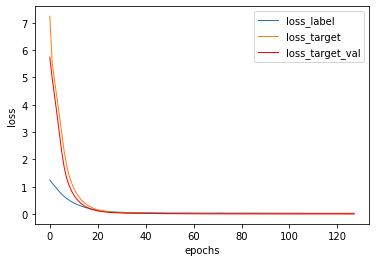

In [64]:
# 検証データの誤差の可視化
fig = plt.figure()
plt.plot(range(len(hist['loss_label'])), hist['loss_label'], linewidth=1,
             label='loss_label')
plt.plot(range(len(hist['loss_target'])), hist['loss_target'], linewidth=1,
             label='loss_target')
plt.plot(range(len(hist['loss_target_val'])), hist['loss_target_val'],
             color='red', linewidth=1,
             label='loss_target_val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 単語ベクトル

In [75]:
word_vec = model.embeddings.weight.data.cpu().numpy()
word_vec.shape

(10911, 300)

In [158]:
class ClassifyDataset(Dataset):
    def __init__(self, df, word2id, word_vec):
        df['word_list'] = df['description'].apply(lambda x: re.sub('\W | \s', '', x).split())
        self.df = df
        self.word2id = word2id
        self.word_vec = word_vec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return sum([self.word_vec[self.word2id[word]] for word in self.df['word_list'][index]]), self.df['jobflag'][index]

In [159]:
dataset = ClassifyDataset(df_train, train_dataset.word2id, word_vec)
X = []
y = []
for i in range(len(dataset)):
    data, label = dataset[i]
    X.append(data)
    y.append(label)
X = np.array(X)
y = np.array(y)

## 分類

## ハイパーパラメータサーチ

In [174]:
import optuna

In [ ]:
XGBClassifier()

In [205]:
#1.目的関数の定義
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 8)
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 0.4)
    alpha = trial.suggest_uniform('alpha', 0.1, 10)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.95, 0.05)


    xgboost_optuna = XGBClassifier(
        random_state=SEED,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        gamma = gamma,
        alpha = alpha
    )
    
    score = cross_val_score(xgboost_optuna, X, y, cv=3, scoring='f1_macro')
    return np.mean(score)

#2.Optunaオブジェクトを作成
study = optuna.create_study(direction='maximize')
#3.Optunaでパラメータ探索
study.optimize(objective, n_trials=20)

#4.ベストパラメータ表示
study.best_params

[I 2020-08-26 12:41:57,868] Trial 0 finished with value: 0.7736638118756277 and parameters: {'max_depth': 3, 'n_estimators': 800, 'min_child_weight': 8, 'gamma': 0.0647548088801653, 'alpha': 3.2302446400832054, 'subsample': 0.95, 'colsample_bytree': 0.75}. Best is trial 0 with value: 0.7736638118756277.
[I 2020-08-26 12:44:37,933] Trial 1 finished with value: 0.7263644247407947 and parameters: {'max_depth': 7, 'n_estimators': 368, 'min_child_weight': 3, 'gamma': 0.32778427153047807, 'alpha': 8.804298073035644, 'subsample': 0.65, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.7736638118756277.
[I 2020-08-26 12:47:48,446] Trial 2 finished with value: 0.7111121065196016 and parameters: {'max_depth': 6, 'n_estimators': 416, 'min_child_weight': 1, 'gamma': 0.350280934541977, 'alpha': 2.45977822621122, 'subsample': 0.65, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7736638118756277.
[I 2020-08-26 12:52:01,648] Trial 3 finished with value: 0.7224995460594611 and parameters

{'alpha': 3.2943248663135773,
 'colsample_bytree': 0.65,
 'gamma': 0.024776807013335143,
 'max_depth': 3,
 'min_child_weight': 10,
 'n_estimators': 949,
 'subsample': 0.8}

## 推論

In [206]:
df_test['jobflag'] = 0

test_dataset = ClassifyDataset(df_test, train_dataset.word2id, word_vec)
X_test = []
for i in range(len(test_dataset)):
    data, _ = dataset[i]
    X_test.append(data)
X_test = np.array(X_test)

In [208]:
xgb_opt = XGBClassifier(
        random_state=SEED,
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_child_weight=study.best_params['min_child_weight'],
        subsample=study.best_params['subsample'],
        colsample_bytree=study.best_params['colsample_bytree'],
        gamma=study.best_params['gamma'],
        alpha=study.best_params['alpha']
    )

xgb_opt.fit(X, y)

pred = xgb_opt.predict(X_test)

              precision    recall  f1-score   support

           1      0.846     0.749     0.794       183
           2      0.875     0.577     0.696        97
           3      0.800     0.955     0.871       423
           4      0.886     0.746     0.810       177

    accuracy                          0.828       880
   macro avg      0.852     0.757     0.793       880
weighted avg      0.835     0.828     0.823       880



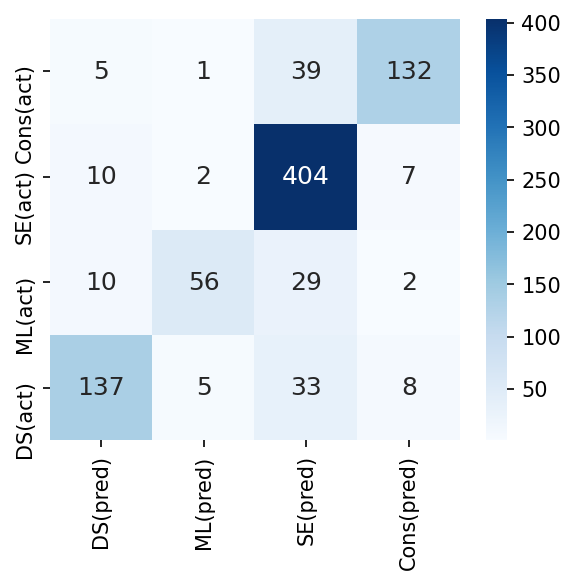

In [210]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)
xgb_opt.fit(X_train, y_train)
pred_val = xgb_opt.predict(X_val)

from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(y_val, pred_val, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(y_val, pred_val, labels=labels, digits=3))

## 提出ファイル作成

In [209]:
submit = pd.read_csv("./dataset/submit_sample.csv", names=["id", "labels"])
submit["labels"] = pred
submit.to_csv("./output/submission_xgboost2.csv", index=False, header=False)